In [3]:
# Cell 1: Install required packages
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn plotly joblib

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

print("All packages installed and imported successfully!")

All packages installed and imported successfully!


In [4]:
# Cell 2: Generate realistic transaction data
def generate_transaction_data(n_samples=50000, fraud_rate=0.05):
    np.random.seed(42)
    
    data = []
    user_profiles = {}
    
    # Create user profiles with normal behavior patterns
    for user_id in range(1, 1001):
        user_profiles[f"user_{user_id}"] = {
            'home_lat': np.random.uniform(35, 45),
            'home_lon': np.random.uniform(-120, -75),
            'avg_amount': np.random.lognormal(4, 0.8),
            'preferred_hour': np.random.normal(15, 3),
            'txn_frequency': np.random.poisson(5) + 1
        }
    
    for i in range(n_samples):
        user_id = f"user_{np.random.randint(1, 1001)}"
        user_profile = user_profiles[user_id]
        
        # Determine if this is fraud
        is_fraud = np.random.random() < fraud_rate
        
        if not is_fraud:
            # Normal transaction pattern
            amount = max(1, np.random.normal(user_profile['avg_amount'], user_profile['avg_amount']*0.3))
            hour = max(0, min(23, np.random.normal(user_profile['preferred_hour'], 3)))
            distance = np.random.exponential(10)  # Usually close to home
            time_since_last = np.random.exponential(3600 * 24 / user_profile['txn_frequency'])
        else:
            # Fraud transaction pattern
            amount = max(1, np.random.normal(user_profile['avg_amount'] * 3, user_profile['avg_amount']))
            hour = np.random.randint(0, 24)  # Random hour for fraud
            distance = np.random.exponential(500)  # Far from home
            time_since_last = np.random.exponential(3600)  # Very recent previous transaction
        
        transaction = {
            'transaction_id': f'txn_{i:06d}',
            'user_id': user_id,
            'timestamp': datetime.now() - timedelta(hours=np.random.randint(0, 720)),
            'amount': amount,
            'hour': hour,
            'is_weekend': 1 if np.random.random() < 0.3 else 0,
            'distance_from_home': distance,
            'time_since_last_txn': time_since_last,
            'num_transactions_last_24h': np.random.poisson(user_profile['txn_frequency']),
            'num_transactions_last_1h': np.random.poisson(0.2),
            'merchant_category': np.random.choice(['retail', 'gas', 'grocery', 'online', 'travel', 'restaurant', 'entertainment']),
            'device_type': np.random.choice(['mobile', 'desktop', 'physical']),
            'is_fraud': is_fraud
        }
        data.append(transaction)
    
    return pd.DataFrame(data)

# Generate the dataset
print("Generating transaction data...")
df = generate_transaction_data(50000, 0.05)
print(f"Dataset created with {len(df)} transactions")
print(f"Fraud rate: {df['is_fraud'].mean():.2%}")

Generating transaction data...
Dataset created with 50000 transactions
Fraud rate: 5.03%


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             50000 non-null  object        
 1   user_id                    50000 non-null  object        
 2   timestamp                  50000 non-null  datetime64[ns]
 3   amount                     50000 non-null  float64       
 4   hour                       50000 non-null  float64       
 5   is_weekend                 50000 non-null  int64         
 6   distance_from_home         50000 non-null  float64       
 7   time_since_last_txn        50000 non-null  float64       
 8   num_transactions_last_24h  50000 non-null  int64         
 9   num_transactions_last_1h   50000 non-null  int64         
 10  merchant_category          50000 non-null  object        
 11  device_type                50000 non-null  object    

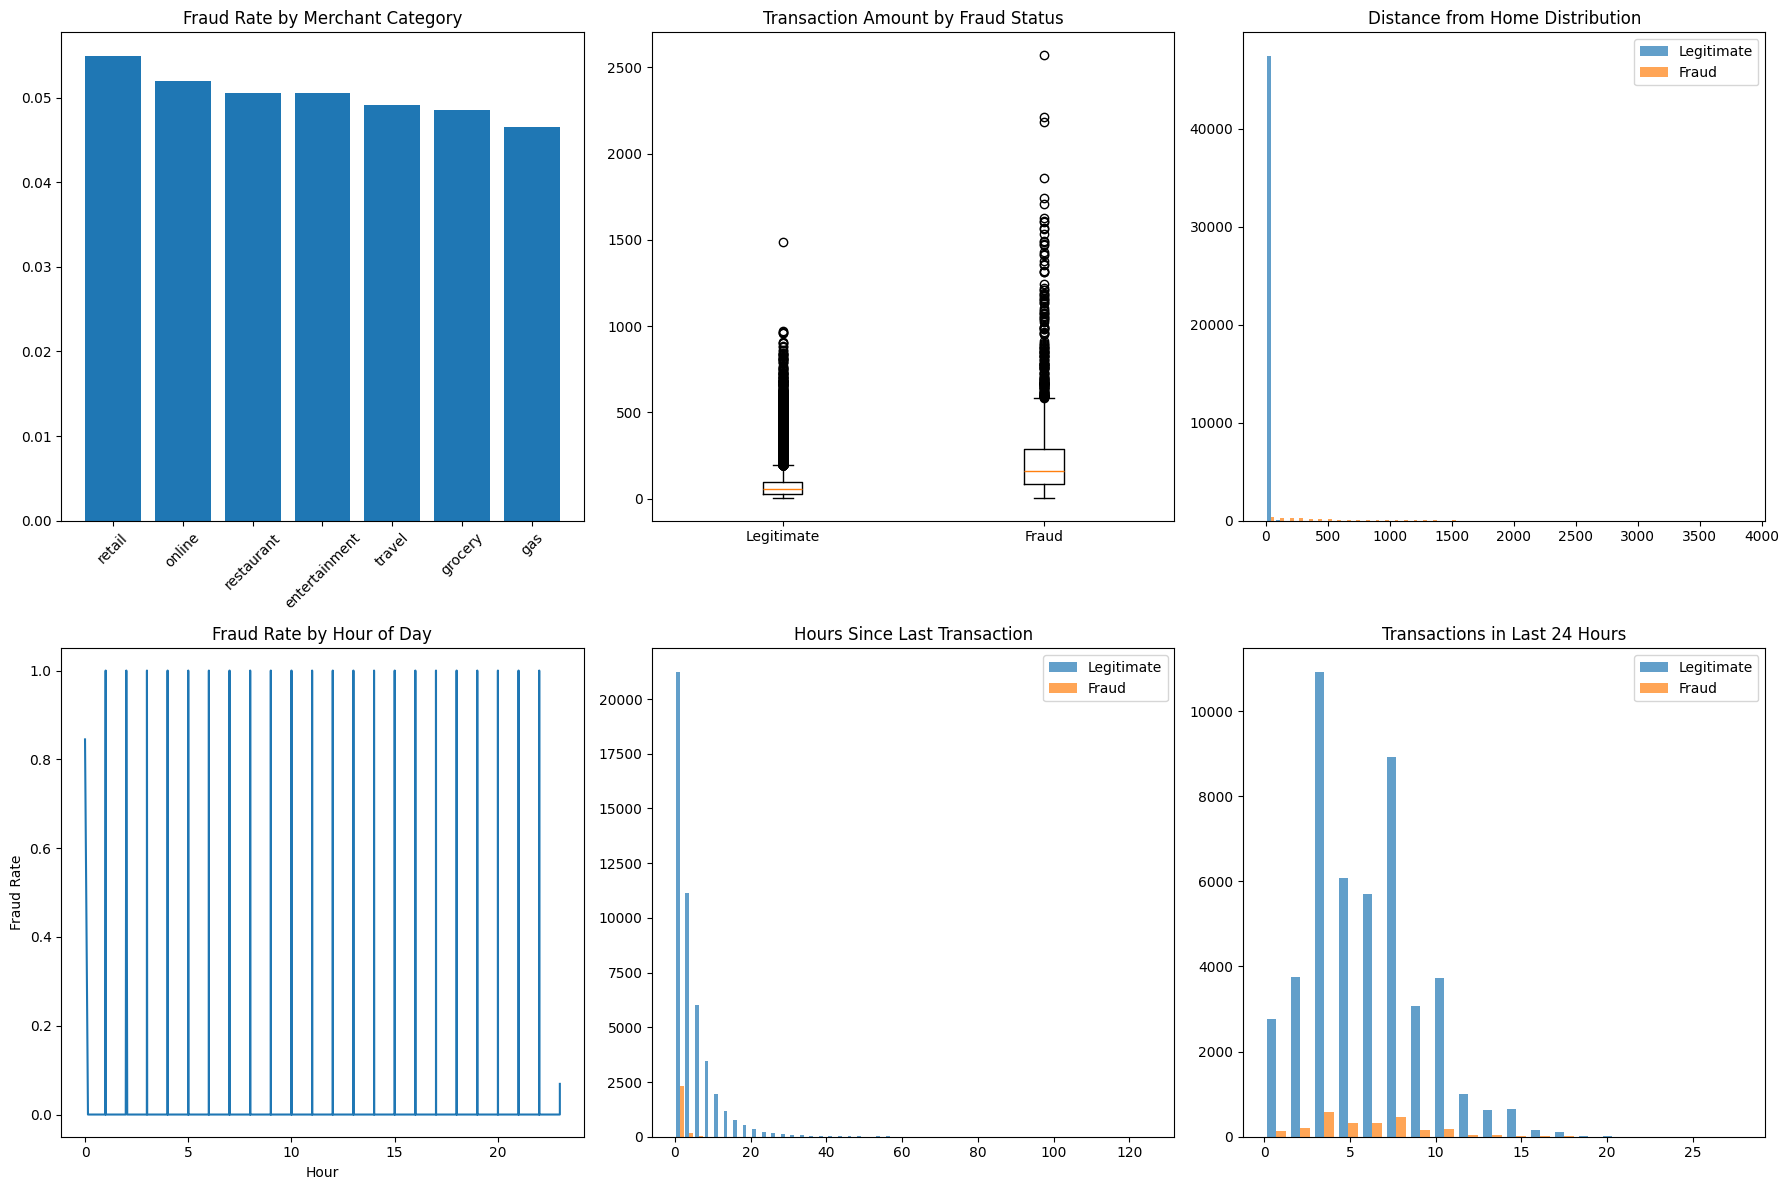

In [5]:
# Cell 3: Data exploration and visualization
print("Dataset Info:")
print(df.info())
print("\nFirst 5 transactions:")
print(df.head())

# Visualize fraud distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Fraud distribution by category
fraud_by_category = df.groupby('merchant_category')['is_fraud'].mean().sort_values(ascending=False)
axes[0,0].bar(fraud_by_category.index, fraud_by_category.values)
axes[0,0].set_title('Fraud Rate by Merchant Category')
axes[0,0].tick_params(axis='x', rotation=45)

# Amount distribution by fraud status
axes[0,1].boxplot([df[df['is_fraud']==0]['amount'], df[df['is_fraud']==1]['amount']], 
                  labels=['Legitimate', 'Fraud'])
axes[0,1].set_title('Transaction Amount by Fraud Status')

# Distance from home
axes[0,2].hist([df[df['is_fraud']==0]['distance_from_home'], 
                df[df['is_fraud']==1]['distance_from_home']], 
               bins=50, alpha=0.7, label=['Legitimate', 'Fraud'])
axes[0,2].set_title('Distance from Home Distribution')
axes[0,2].legend()

# Transactions per hour
hourly_fraud = df.groupby('hour')['is_fraud'].mean()
axes[1,0].plot(hourly_fraud.index, hourly_fraud.values)
axes[1,0].set_title('Fraud Rate by Hour of Day')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Fraud Rate')

# Time since last transaction
axes[1,1].hist([df[df['is_fraud']==0]['time_since_last_txn']/3600, 
                df[df['is_fraud']==1]['time_since_last_txn']/3600], 
               bins=50, alpha=0.7, label=['Legitimate', 'Fraud'])
axes[1,1].set_title('Hours Since Last Transaction')
axes[1,1].legend()

# Transaction velocity
axes[1,2].hist([df[df['is_fraud']==0]['num_transactions_last_24h'], 
                df[df['is_fraud']==1]['num_transactions_last_24h']], 
               bins=20, alpha=0.7, label=['Legitimate', 'Fraud'])
axes[1,2].set_title('Transactions in Last 24 Hours')
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [6]:
# Cell 4: Advanced feature engineering
def create_advanced_features(df):
    df_features = df.copy()
    
    # Encode categorical variables
    le_merchant = LabelEncoder()
    le_device = LabelEncoder()
    df_features['merchant_encoded'] = le_merchant.fit_transform(df_features['merchant_category'])
    df_features['device_encoded'] = le_device.fit_transform(df_features['device_type'])
    
    # Create advanced features
    df_features['amount_to_avg_ratio'] = df_features['amount'] / df_features.groupby('user_id')['amount'].transform('mean')
    df_features['hour_deviation'] = abs(df_features['hour'] - df_features.groupby('user_id')['hour'].transform('median'))
    df_features['is_night'] = ((df_features['hour'] >= 0) & (df_features['hour'] <= 5)).astype(int)
    df_features['is_rush_hour'] = ((df_features['hour'] >= 7) & (df_features['hour'] <= 9)) | ((df_features['hour'] >= 16) & (df_features['hour'] <= 18))
    df_features['is_unusual_time'] = ((df_features['hour'] >= 1) & (df_features['hour'] <= 4)).astype(int)
    
    # Behavioral features
    df_features['txn_velocity_1h'] = df_features['num_transactions_last_1h']
    df_features['txn_velocity_24h'] = df_features['num_transactions_last_24h']
    df_features['high_velocity_flag'] = (df_features['txn_velocity_1h'] > 3).astype(int)
    
    # Risk scoring features
    df_features['distance_risk'] = np.log1p(df_features['distance_from_home'])
    df_features['amount_risk'] = np.log1p(df_features['amount'])
    df_features['time_risk'] = (df_features['time_since_last_txn'] < 300).astype(int)  # Less than 5 minutes
    
    return df_features

# Create features
print("Creating advanced features...")
df_features = create_advanced_features(df)

# Select final features for modeling
feature_columns = [
    'amount', 'hour', 'is_weekend', 'distance_from_home', 
    'time_since_last_txn', 'num_transactions_last_24h', 'num_transactions_last_1h',
    'merchant_encoded', 'device_encoded', 'amount_to_avg_ratio', 
    'hour_deviation', 'is_night', 'is_rush_hour', 'is_unusual_time',
    'txn_velocity_1h', 'txn_velocity_24h', 'high_velocity_flag',
    'distance_risk', 'amount_risk', 'time_risk'
]

X = df_features[feature_columns]
y = df_features['is_fraud']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Creating advanced features...
Feature matrix shape: (50000, 20)
Target distribution:
is_fraud
False    47484
True      2516
Name: count, dtype: int64


In [7]:
# Cell 5: Train multiple fraud detection models
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train supervised model (Random Forest)
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)

# Train anomaly detection model (Isolation Forest)
print("Training Isolation Forest model...")
iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
iso_model.fit(X_train_scaled)

print("Model training completed!")

Training set: (35000, 20)
Test set: (15000, 20)
Training Random Forest model...
Training Isolation Forest model...
Model training completed!


=== RANDOM FOREST PERFORMANCE ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     14245
       Fraud       0.96      0.99      0.97       755

    accuracy                           1.00     15000
   macro avg       0.98      0.99      0.99     15000
weighted avg       1.00      1.00      1.00     15000

ROC-AUC Score: 0.9998

=== ISOLATION FOREST PERFORMANCE ===
              precision    recall  f1-score   support

  Legitimate       0.98      0.98      0.98     14245
       Fraud       0.69      0.68      0.69       755

    accuracy                           0.97     15000
   macro avg       0.84      0.83      0.84     15000
weighted avg       0.97      0.97      0.97     15000



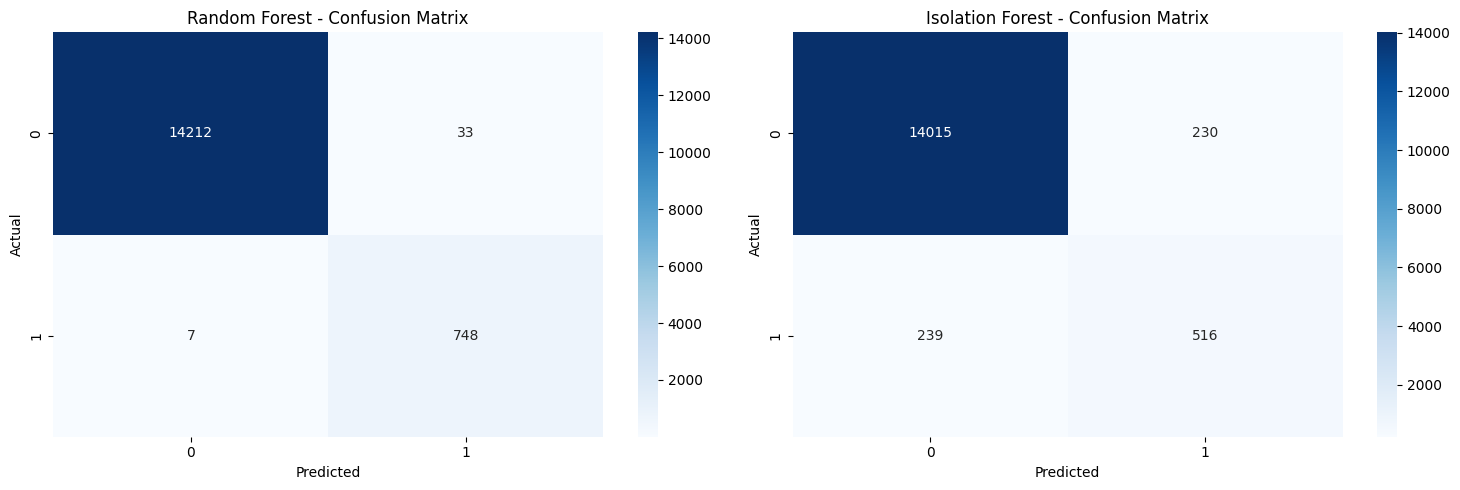

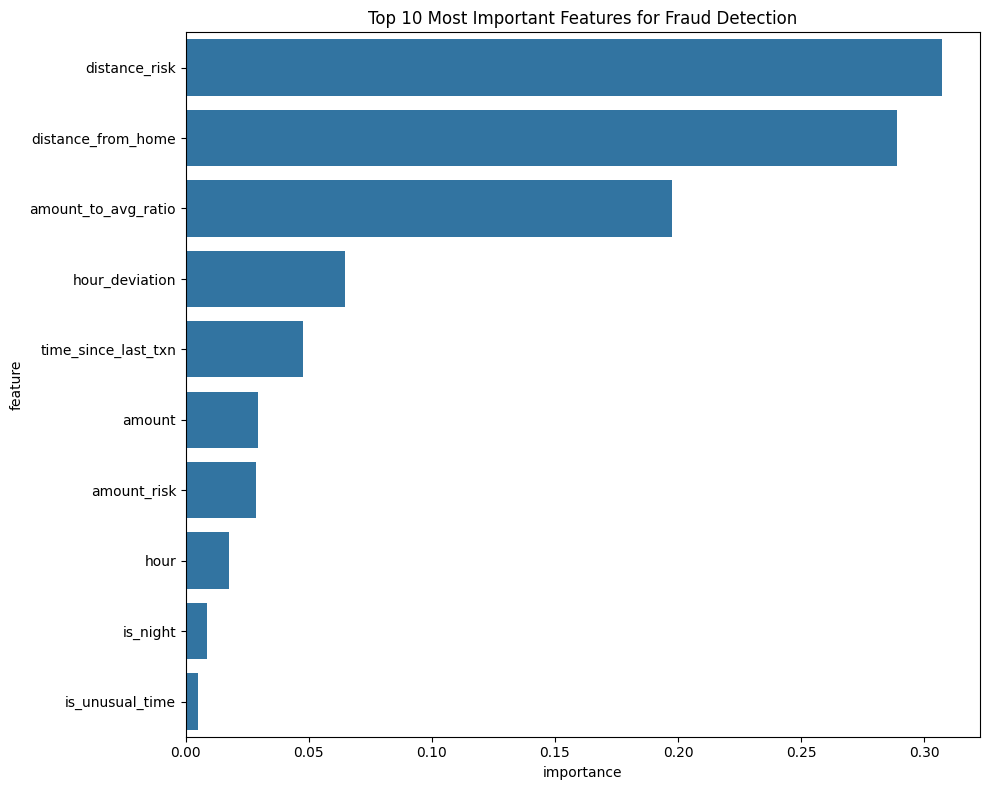

In [8]:
# Cell 6: Evaluate model performance
# Supervised model predictions
rf_predictions = rf_model.predict(X_test_scaled)
rf_probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]

# Anomaly detection predictions (convert to same format: 1=fraud, 0=legitimate)
iso_predictions = iso_model.predict(X_test_scaled)
iso_predictions = [1 if x == -1 else 0 for x in iso_predictions]  # Convert to fraud labels

print("=== RANDOM FOREST PERFORMANCE ===")
print(classification_report(y_test, rf_predictions, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_probabilities):.4f}")

print("\n=== ISOLATION FOREST PERFORMANCE ===")
print(classification_report(y_test, iso_predictions, target_names=['Legitimate', 'Fraud']))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Isolation Forest Confusion Matrix
cm_iso = confusion_matrix(y_test, iso_predictions)
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Isolation Forest - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features for Fraud Detection')
plt.tight_layout()
plt.show()

In [9]:
# Cell 7: Simulate real-time fraud detection
class RealTimeFraudDetector:
    def __init__(self, supervised_model, anomaly_model, scaler, feature_columns):
        self.supervised_model = supervised_model
        self.anomaly_model = anomaly_model
        self.scaler = scaler
        self.feature_columns = feature_columns
        self.user_history = {}
    
    def extract_features(self, transaction):
        """Extract real-time features from a transaction"""
        user_id = transaction['user_id']
        
        # Update user history
        if user_id not in self.user_history:
            self.user_history[user_id] = {
                'transactions': [],
                'last_timestamp': None,
                'amounts': []
            }
        
        user_history = self.user_history[user_id]
        
        # Calculate real-time features
        features = {}
        features['amount'] = transaction['amount']
        features['hour'] = transaction['hour']
        features['is_weekend'] = transaction['is_weekend']
        features['distance_from_home'] = transaction['distance_from_home']
        features['num_transactions_last_24h'] = transaction['num_transactions_last_24h']
        features['num_transactions_last_1h'] = transaction['num_transactions_last_1h']
        features['merchant_encoded'] = transaction['merchant_encoded']
        features['device_encoded'] = transaction['device_encoded']
        
        # Time-based features
        if user_history['last_timestamp']:
            time_since_last = (transaction['timestamp'] - user_history['last_timestamp']).total_seconds()
        else:
            time_since_last = 3600 * 24  # Default 24 hours if no history
        features['time_since_last_txn'] = time_since_last
        
        # Behavioral features
        user_avg_amount = np.mean(user_history['amounts']) if user_history['amounts'] else transaction['amount']
        features['amount_to_avg_ratio'] = transaction['amount'] / user_avg_amount if user_avg_amount > 0 else 1
        features['hour_deviation'] = abs(transaction['hour'] - 14)  # Simple deviation from typical hour
        
        # Risk features
        features['is_night'] = 1 if 0 <= transaction['hour'] <= 5 else 0
        features['is_rush_hour'] = 1 if (7 <= transaction['hour'] <= 9) or (16 <= transaction['hour'] <= 18) else 0
        features['is_unusual_time'] = 1 if 1 <= transaction['hour'] <= 4 else 0
        features['txn_velocity_1h'] = transaction['num_transactions_last_1h']
        features['txn_velocity_24h'] = transaction['num_transactions_last_24h']
        features['high_velocity_flag'] = 1 if transaction['num_transactions_last_1h'] > 3 else 0
        features['distance_risk'] = np.log1p(transaction['distance_from_home'])
        features['amount_risk'] = np.log1p(transaction['amount'])
        features['time_risk'] = 1 if time_since_last < 300 else 0
        
        # Update user history
        user_history['transactions'].append(transaction)
        user_history['last_timestamp'] = transaction['timestamp']
        user_history['amounts'].append(transaction['amount'])
        
        # Keep only last 100 transactions for memory efficiency
        if len(user_history['transactions']) > 100:
            user_history['transactions'] = user_history['transactions'][-100:]
            user_history['amounts'] = user_history['amounts'][-100:]
        
        return features
    
    def predict(self, transaction):
        """Predict if a transaction is fraudulent"""
        # Extract features
        features_dict = self.extract_features(transaction)
        
        # Convert to array in correct feature order
        feature_array = np.array([[features_dict[col] for col in self.feature_columns]])
        
        # Scale features
        feature_array_scaled = self.scaler.transform(feature_array)
        
        # Get predictions from both models
        supervised_score = self.supervised_model.predict_proba(feature_array_scaled)[0, 1]
        anomaly_score = self.anomaly_model.decision_function(feature_array_scaled)[0]
        
        # Convert anomaly score to probability-like score (lower = more anomalous)
        anomaly_prob = 1 / (1 + np.exp(-anomaly_score * 10))  # Sigmoid transformation
        
        # Combined score (weighted average)
        combined_score = 0.7 * supervised_score + 0.3 * anomaly_prob
        
        # Decision logic
        if combined_score > 0.8:
            decision = "BLOCK"
            reason = "High confidence fraud detected"
        elif combined_score > 0.6:
            decision = "REVIEW"
            reason = "Suspicious activity - manual review needed"
        else:
            decision = "ALLOW"
            reason = "Transaction appears legitimate"
        
        return {
            'decision': decision,
            'supervised_score': supervised_score,
            'anomaly_score': anomaly_prob,
            'combined_score': combined_score,
            'reason': reason,
            'features': features_dict
        }

# Initialize the fraud detector
fraud_detector = RealTimeFraudDetector(rf_model, iso_model, scaler, feature_columns)

# Test with sample real-time transactions
print("Testing real-time fraud detection...\n")

# Create test transactions
test_transactions = [
    {
        'transaction_id': 'test_1',
        'user_id': 'user_50',
        'timestamp': datetime.now(),
        'amount': 45.50,
        'hour': 14,
        'is_weekend': 0,
        'distance_from_home': 5.2,
        'num_transactions_last_24h': 2,
        'num_transactions_last_1h': 1,
        'merchant_category': 'grocery',
        'device_type': 'mobile',
        'merchant_encoded': 2,  # grocery
        'device_encoded': 0     # mobile
    },
    {
        'transaction_id': 'test_2', 
        'user_id': 'user_50',
        'timestamp': datetime.now(),
        'amount': 1250.00,
        'hour': 3,
        'is_weekend': 1,
        'distance_from_home': 1200.5,
        'num_transactions_last_24h': 8,
        'num_transactions_last_1h': 3,
        'merchant_category': 'travel',
        'device_type': 'desktop',
        'merchant_encoded': 4,  # travel
        'device_encoded': 1     # desktop
    }
]

# Process test transactions
for i, txn in enumerate(test_transactions, 1):
    print(f"Processing Transaction {i}:")
    print(f"  Amount: ${txn['amount']:.2f}, Merchant: {txn['merchant_category']}, Hour: {txn['hour']}:00")
    print(f"  Distance: {txn['distance_from_home']:.1f} miles, Recent TXNs: {txn['num_transactions_last_1h']} in last hour")
    
    result = fraud_detector.predict(txn)
    
    print(f"  Result: {result['decision']}")
    print(f"  Reason: {result['reason']}")
    print(f"  Scores - Supervised: {result['supervised_score']:.3f}, Anomaly: {result['anomaly_score']:.3f}, Combined: {result['combined_score']:.3f}")
    print("-" * 60)

Testing real-time fraud detection...

Processing Transaction 1:
  Amount: $45.50, Merchant: grocery, Hour: 14:00
  Distance: 5.2 miles, Recent TXNs: 1 in last hour
  Result: ALLOW
  Reason: Transaction appears legitimate
  Scores - Supervised: 0.002, Anomaly: 0.645, Combined: 0.195
------------------------------------------------------------
Processing Transaction 2:
  Amount: $1250.00, Merchant: travel, Hour: 3:00
  Distance: 1200.5 miles, Recent TXNs: 3 in last hour
  Result: REVIEW
  Reason: Suspicious activity - manual review needed
  Scores - Supervised: 0.999, Anomaly: 0.100, Combined: 0.729
------------------------------------------------------------


In [10]:
# Cell 8: Save the trained models
import joblib

# Create a model package
model_package = {
    'supervised_model': rf_model,
    'anomaly_model': iso_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'feature_importance': feature_importance,
    'metadata': {
        'training_date': datetime.now().strftime("%Y-%m-%d"),
        'dataset_size': len(df),
        'fraud_rate': df['is_fraud'].mean(),
        'performance_auc': roc_auc_score(y_test, rf_probabilities)
    }
}

# Save the model package
joblib.dump(model_package, 'fraud_detection_model.pkl')
print("Model saved as 'fraud_detection_model.pkl'")

# Verify the model can be loaded
loaded_model = joblib.load('fraud_detection_model.pkl')
print("Model loaded successfully!")
print(f"Model trained on: {loaded_model['metadata']['training_date']}")
print(f"Performance AUC: {loaded_model['metadata']['performance_auc']:.4f}")

Model saved as 'fraud_detection_model.pkl'
Model loaded successfully!
Model trained on: 2025-10-21
Performance AUC: 0.9998


Generating monitoring dashboard...


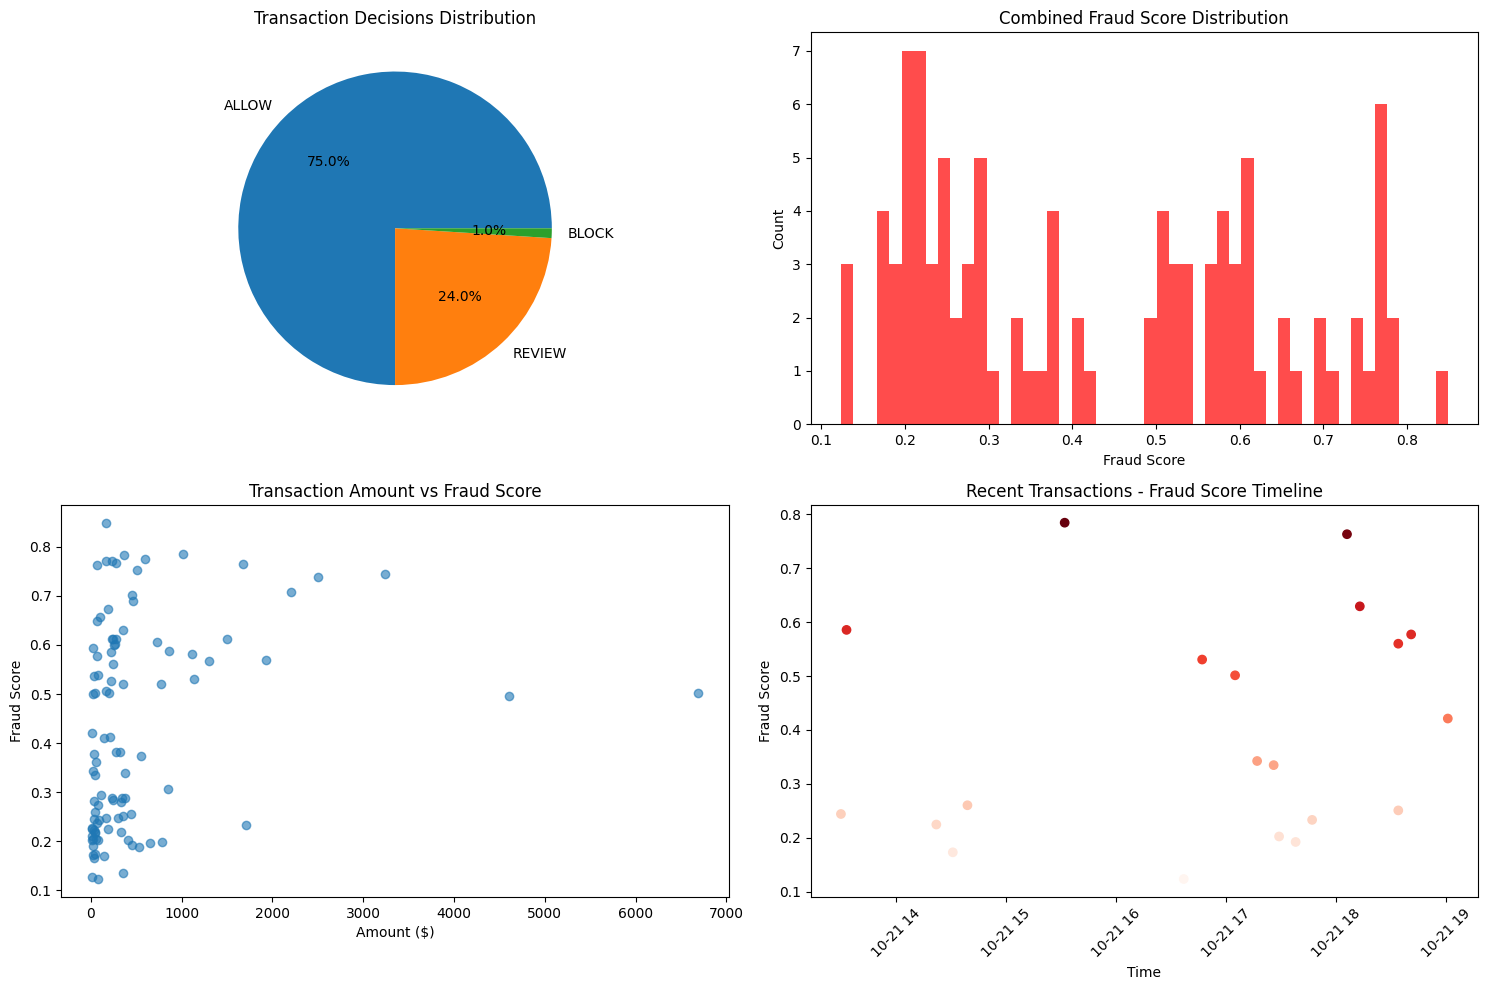

=== FRAUD DETECTION DASHBOARD ===
Total Transactions Monitored: 100
Blocked Transactions: 1
Review Required: 24
Average Fraud Score: 0.428
Highest Fraud Score: 0.849


In [11]:
# Cell 9: Simple monitoring dashboard
def create_monitoring_dashboard(detector, recent_transactions=100):
    """Create a simple monitoring dashboard"""
    
    # Simulate some transaction history for the dashboard
    np.random.seed(42)
    dashboard_data = []
    
    for i in range(recent_transactions):
        is_fraud = np.random.random() < 0.1
        amount = np.random.lognormal(5, 1.5) if not is_fraud else np.random.lognormal(7, 1)
        
        txn = {
            'transaction_id': f'dash_txn_{i}',
            'user_id': f'user_{np.random.randint(1, 100)}',
            'timestamp': datetime.now() - timedelta(minutes=np.random.randint(0, 1440)),
            'amount': amount,
            'hour': np.random.randint(0, 24),
            'is_weekend': np.random.choice([0, 1]),
            'distance_from_home': np.random.exponential(50 if not is_fraud else 300),
            'num_transactions_last_24h': np.random.poisson(3),
            'num_transactions_last_1h': np.random.poisson(0.5),
            'merchant_category': np.random.choice(['retail', 'gas', 'grocery', 'online']),
            'device_type': 'mobile',
            'merchant_encoded': 1,
            'device_encoded': 0
        }
        
        result = detector.predict(txn)
        txn.update(result)
        dashboard_data.append(txn)
    
    dashboard_df = pd.DataFrame(dashboard_data)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Decision distribution
    decision_counts = dashboard_df['decision'].value_counts()
    axes[0,0].pie(decision_counts.values, labels=decision_counts.index, autopct='%1.1f%%')
    axes[0,0].set_title('Transaction Decisions Distribution')
    
    # Fraud score distribution
    axes[0,1].hist(dashboard_df['combined_score'], bins=50, alpha=0.7, color='red')
    axes[0,1].set_title('Combined Fraud Score Distribution')
    axes[0,1].set_xlabel('Fraud Score')
    axes[0,1].set_ylabel('Count')
    
    # Amount vs Fraud Score
    axes[1,0].scatter(dashboard_df['amount'], dashboard_df['combined_score'], alpha=0.6)
    axes[1,0].set_title('Transaction Amount vs Fraud Score')
    axes[1,0].set_xlabel('Amount ($)')
    axes[1,0].set_ylabel('Fraud Score')
    
    # Recent transactions timeline
    recent = dashboard_df.nlargest(20, 'timestamp')
    axes[1,1].scatter(recent['timestamp'], recent['combined_score'], c=recent['combined_score'], cmap='Reds')
    axes[1,1].set_title('Recent Transactions - Fraud Score Timeline')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Fraud Score')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== FRAUD DETECTION DASHBOARD ===")
    print(f"Total Transactions Monitored: {len(dashboard_df)}")
    print(f"Blocked Transactions: {len(dashboard_df[dashboard_df['decision'] == 'BLOCK'])}")
    print(f"Review Required: {len(dashboard_df[dashboard_df['decision'] == 'REVIEW'])}")
    print(f"Average Fraud Score: {dashboard_df['combined_score'].mean():.3f}")
    print(f"Highest Fraud Score: {dashboard_df['combined_score'].max():.3f}")
    
    return dashboard_df

# Run the dashboard
print("Generating monitoring dashboard...")
dashboard_data = create_monitoring_dashboard(fraud_detector)